In [1]:
import numpy as np
import random as rd
import scipy as sci
import matplotlib.pyplot as plt
import itertools as it
from scipy.optimize import fsolve
from collections import Counter
from itertools import islice, combinations
#plt.rcParams["font.family"] = "Times New Roman"
#plt.rcParams["figure.figsize"] = (4,3)
#plt.rcParams.update({"text.usetex": True, "font.family": "Helvetica"})
from scipy.interpolate import interp1d
from scipy import stats, integrate

# functions

In [76]:
def smartlog(a,b):
    if(a != 0 and b != 0):
        return np.log(a/b)
    return 0

def simplified_Brusselator(A, B, V, rates, tmax):
    [k1,km1,k2,km2,k3,km3] = rates
    X = 10
    Y = 10
    t = 0
    traj = []
    trajAB = []
    times = []
    timesAB = []
    Σ = 0

    # burner
    while t < 10:

        r1 = A*k1
        rm1 = X*km1
        r2 = B*k2
        rm2 = Y*km2
        r3 = X*(X-1)*Y*k3/(V**2)
        rm3 = X*(X-1)*(X-2)*km3/(V**2)
        tot = r1 + rm1 + r2 + rm2 + r3 + rm3

        r = tot*rd.random()

        if r <= r1:
            X += 1
        elif r <= r1 + rm1:
            X -= 1
        elif r <= r1 + rm1 + r2:
            Y += 1
        elif r <= r1 + rm1 + r2 + rm2:
            Y -= 1
        elif r <= r1 + rm1 + r2 + rm2 + r3:
            X += 1
            Y -= 1
        else:
            X -= 1
            Y += 1
        t += -np.log(rd.random())/tot

    t = 0
    while t < tmax:

        r1 = A*k1
        rm1 = X*km1
        r2 = B*k2
        rm2 = Y*km2
        #r3 = (X**2)*Y*k3
        #rm3 = (X**3)*km3
        r3 = X*(X-1)*Y*k3/(V**2)
        rm3 = X*(X-1)*(X-2)*km3/(V**2)
        tot = r1 + rm1 + r2 + rm2 + r3 + rm3

        r = tot*rd.random()
        t += -np.log(rd.random())/tot

        if r <= r1:
            X += 1
            traj.append('pA')
            times.append(t)
            trajAB.append('pA')
            timesAB.append(t)
            Σ += smartlog(r1,X*km1)
        elif r <= r1 + rm1:
            X -= 1
            traj.append('mA')
            times.append(t)
            trajAB.append('mA')
            timesAB.append(t)
            Σ += smartlog(rm1,r1)
        elif r <= r1 + rm1 + r2:
            Y += 1
            traj.append('pB')
            times.append(t)
            trajAB.append('pB')
            timesAB.append(t)
            Σ += smartlog(r2,Y*km2)
        elif r <= r1 + rm1 + r2 + rm2:
            Y -= 1
            traj.append('mB')
            times.append(t)
            trajAB.append('mB')
            timesAB.append(t)
            Σ += smartlog(rm2,r2)
        elif r <= r1 + rm1 + r2 + rm2 + r3:
            X += 1
            Y -= 1
            traj.append('pC')
            times.append(t)
            Σ += smartlog(r3,X*(X-1)*(X-2)*km3/(V**2))
        else:
            X -= 1
            Y += 1
            traj.append('mC')
            times.append(t)
            Σ += smartlog(rm3,X*(X-1)*Y*k3/(V**2))


    return traj, times, Σ/tmax, trajAB, timesAB

def count_pairs(array,n=2):
    c1 = Counter(zip(*[islice(array,i,None) for i in range(n)]))
    total = 1.0 * (len(array) - n + 1)
    for k in c1:
        c1[k] /= total
    
    return c1

def cumcount_reduced(arr):
    '''Returns the step function value at each increment of the CDF'''
    sorted_arr = np.array(sorted(arr))
    counts = np.zeros(len(arr))
    
    rolling_count = 0
    for idx, elem in enumerate(sorted_arr):
        rolling_count += 1
        counts[idx] = rolling_count

    counts /= len(counts)
    counts -= (1 / (2 * len(counts)))

    return (sorted_arr, counts)


def KLD_PerezCruz(P, Q, eps=1e-11):
    '''takes two datasets to estimate the relative entropy between their PDFs
    we use eps=10^-11, but it could be defined as < the minimal interval between data points'''
    P = sorted(P)
    Q = sorted(Q)
    
    P_positions, P_counts = cumcount_reduced(P)
    Q_positions, Q_counts = cumcount_reduced(Q)
    
    #definition of x_0 and x_{n+1}
    x_0 = np.min([P_positions[0], Q_positions[0]]) - 1
    P_positions = np.insert(P_positions, 0, [x_0])
    P_counts = np.insert(P_counts, 0, [0])
    Q_positions = np.insert(Q_positions, 0, [x_0])
    Q_counts = np.insert(Q_counts, 0, [0])
    
    x_np1 = np.max([P_positions[-1], Q_positions[-1]]) + 1
    P_positions = np.append(P_positions, [x_np1])
    P_counts = np.append(P_counts, [1])
    Q_positions = np.append(Q_positions, [x_np1])
    Q_counts = np.append(Q_counts, [1])
    
    f_P = interp1d(P_positions, P_counts)
    f_Q = interp1d(Q_positions, Q_counts) 
    
    X = P_positions[1:-2]
    values = (f_P(X) - f_P(X - eps)) / (f_Q(X) - f_Q(X - eps))
    filt = ((values != 0.) & ~(np.isinf(values)) & ~(np.isnan(values)))
    values_filter = values[filt]
    out = (np.sum(np.log(values_filter)) / len(values_filter)) - 1.

    return out

x_dict = {
    "pA" : 0,
    "mA" : 1,
    "pB" : 2,
    "mB" : 3
}

rev = {
    "pA" : "mA",
    "mA" : "pA",
    "pB" : "mB",
    "mB" : "pB",
    "pC" : "mC",
    "mC" : "pC"
}

# calculating the estimators

In [55]:
%%time
[k1, km1, k2, km2, k3, km3] = [3, 2, 2, 3, 3, 1]
A = 20
B = 10
V = 2
tmax = 10**4

traj, times, epr, trajAB, timesAB = simplified_Brusselator(A, B, V, [k1, km1, k2, km2, k3, km3], tmax)

CPU times: user 5min 57s, sys: 1.32 s, total: 5min 58s
Wall time: 5min 58s


In [92]:
Δμ = np.log( (B * k2 * km1 * k3)/(A * km2 * k1 * km3) )

# σ_zk
K = len(trajAB)/tmax
count = Counter(trajAB)
PpA = count['pA']/len(trajAB)
PmA = count['mA']/len(trajAB)
PpB = count['pB']/len(trajAB)
PmB = count['mB']/len(trajAB)
σzk = K * (PpA - PmA) * smartlog( PpA, PmA ) + K * (PpB - PmB) * smartlog( PpB, PmB )

In [95]:
# Dx and Dt
counts2 = count_pairs(trajAB, 2)
Xspace = ['pA', 'mA', 'pB', 'mB']
Pt = [  [[],[],[],[]],
        [[],[],[],[]],
        [[],[],[],[]],
        [[],[],[],[]]  ]
for i in range(len(trajAB)-1):
    x1 = x_dict[trajAB[i]]
    x2 = x_dict[trajAB[i+1]]
    Pt[ x1 ][ x2 ].append( timesAB[i+1] - timesAB[i] )

Dx = 0
Dt = 0
for x1 in Xspace:
    for x2 in Xspace:
        Px1x2 = counts2[ (x1, x2) ]
        Px1x2r = counts2[ (rev[x2], rev[x1]) ]
        Dx += Px1x2 * smartlog( Px1x2, Px1x2r )
        
        c1 = clicks_dict[x1]
        c2 = clicks_dict[x2]
        c1r = clicks_dict[rev[x1]]
        c2r = clicks_dict[rev[x2]]
        if c1 != c2r:
            Px1x2 = counts2[ (x1, x2) ]
            kld = KLD_PerezCruz(Pt[c1][c2], Pt[c2r][c1r])
            Dt += Px1x2*kld

/tmp/ipykernel_11745/3086604479.py:156: RuntimeWarning: divide by zero encountered in true_divide
  values = (f_P(X) - f_P(X - eps)) / (f_Q(X) - f_Q(X - eps))


In [98]:
[epr, σzk, Dx, Dt]

[2.695754254123182,
 2.6884772900897786,
 0.033668507413591224,
 -0.0013584896769661505]

# plot

In [244]:
%%time
[k1, km1, k2, km2, k3, km3] = [3, 2, 2, 3, 3, 1]
B = 10
V = 2
tmax = 10**4
reps = 10

vecs = []

for rep in range(reps):
    vec = []
    for A in np.linspace(9,20,15):

        traj, times, epr, trajAB, timesAB = simplified_Brusselator(A, B, V, [k1, km1, k2, km2, k3, km3], tmax)
        Δμ = np.log( (B * k2 * km1 * k3)/(A * km2 * k1 * km3) )

        # σ_zk
        K = len(trajAB)/tmax
        count = Counter(trajAB)
        PpA = count['pA']/len(trajAB)
        PmA = count['mA']/len(trajAB)
        PpB = count['pB']/len(trajAB)
        PmB = count['mB']/len(trajAB)
        [σzkA, σzkB] = [ K * (PpA - PmA) * smartlog( PpA, PmA ) , K * (PpB - PmB) * smartlog( PpB, PmB ) ]

        # Dx and Dt
        counts2 = count_pairs(trajAB, 2)
        Xspace = ['pA', 'mA', 'pB', 'mB']
        Pt = [  [[],[],[],[]],
                [[],[],[],[]],
                [[],[],[],[]],
                [[],[],[],[]]  ]
        for i in range(len(trajAB)-1):
            x1 = x_dict[trajAB[i]]
            x2 = x_dict[trajAB[i+1]]
            Pt[ x1 ][ x2 ].append( timesAB[i+1] - timesAB[i] )
        Dx = 0
        Dt = 0
        for x1 in Xspace:
            for x2 in Xspace:
                Px1x2 = counts2[ (x1, x2) ]
                Px1x2r = counts2[ (rev[x2], rev[x1]) ]
                Dx += Px1x2 * smartlog( Px1x2, Px1x2r )

                c1 = clicks_dict[x1]
                c2 = clicks_dict[x2]
                c1r = clicks_dict[rev[x1]]
                c2r = clicks_dict[rev[x2]]
                if c1 != c2r:
                    Px1x2 = counts2[ (x1, x2) ]
                    kld = KLD_PerezCruz(Pt[c1][c2], Pt[c2r][c1r])
                    Dt += Px1x2*kld

        # σti
        counts3 = count_pairs(traj, 3)
        A1 = smartlog( counts3[ ('mA', 'pB', 'pC') ], counts3[ ('mC', 'mB', 'pA') ])
        A2 = smartlog( counts3[ ('pC', 'mA', 'pB') ], counts3[ ('mB', 'pA', 'mC') ])
        A3 = smartlog( counts3[ ('pB', 'pC', 'mA') ], counts3[ ('pA', 'mC', 'mB') ])
        affinity = np.mean([A1, A2, A3])
        J = - K * (PpA - PmA)

        vec.append( [Δμ, epr, σzkA, σzkB, Dx, Dt, J, A1, A2, A3] )
    
    vecs.append(vec)

/tmp/ipykernel_11745/3086604479.py:156: RuntimeWarning: divide by zero encountered in true_divide
  values = (f_P(X) - f_P(X - eps)) / (f_Q(X) - f_Q(X - eps))


CPU times: user 13h 46min 56s, sys: 2min 33s, total: 13h 49min 29s
Wall time: 13h 49min 30s


In [245]:
aff_mean = []
epr_mean = []
epr_std = []
σzkB_mean = []
σzkB_std = []
σzk_mean = []
σzk_std = []
Dx_mean = []
Dx_std = []
Dt_mean = []
Dt_std = []
σti_mean = []
σti_std = []

for i in range(len(vec)):
    
    affinities = [x[i][0] for x in vecs]
    aff_mean.append( np.mean( affinities ) )
    
    eprs = [x[i][1] for x in vecs]
    epr_mean.append( np.mean( eprs ) )    
    epr_std.append( np.std( eprs ) )
    
    σzkBs = [x[i][3] for x in vecs]
    σzkB_mean.append( np.mean( σzkBs ) )
    σzkB_std.append( np.std( σzkBs ) )
    
    σzks = [x[i][3]+x[i][2] for x in vecs]
    σzk_mean.append( np.mean( σzks ) )
    σzk_std.append( np.std( σzks ) )
    
    Dxs = [x[i][4] for x in vecs]
    Dx_mean.append( np.mean( Dxs ) )
    Dx_std.append( np.std( Dxs ) )
    
    Dts = [x[i][5] for x in vecs]
    Dt_mean.append( np.mean( Dts ) )
    Dt_std.append( np.std( Dts ) )
    
    σtis = [ x[i][6]*np.mean( [x[i][7], x[i][8], x[i][9]] ) for x in vecs]
    σti_mean.append( np.mean( σtis ) )
    σti_std.append( np.std( σtis ) )

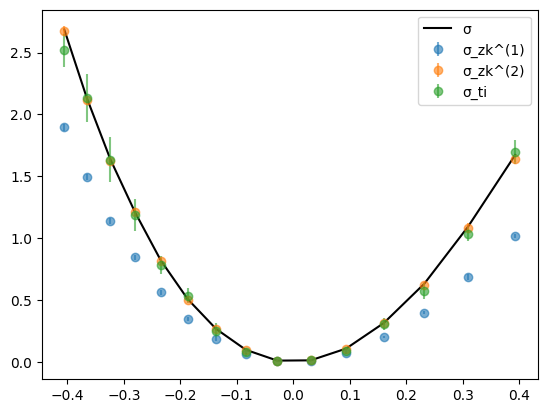

In [253]:
plt.plot(aff_mean, epr_mean, "-", label = 'σ', color = 'k')
plt.errorbar(aff_mean, σzkB_mean, yerr = σzkB_std, fmt="o", alpha = 0.6, label = 'σ_zk^(1)')
plt.errorbar(aff_mean, σzk_mean, yerr = σzk_std, fmt="o", alpha = 0.6, label = 'σ_zk^(2)')
plt.errorbar(aff_mean, σti_mean, yerr = σti_std, fmt="o", alpha = 0.6, label = 'σ_ti')
plt.legend()
plt.show()

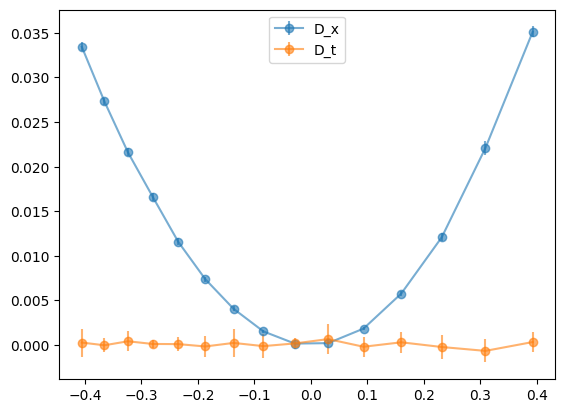

In [254]:
plt.errorbar(aff_mean, Dx_mean, yerr = Dx_std, fmt="o-", alpha = 0.6, label = 'D_x')
plt.errorbar(aff_mean, Dt_mean, yerr = Dt_std, fmt="o-", alpha = 0.6, label = 'D_t')
plt.legend()
plt.show()

In [261]:
np.savetxt('bruss_simulation_results.txt', np.array([aff_mean, epr_mean, epr_std, σzkB_mean, σzkB_std, σzk_mean, σzk_std, σti_mean, σti_std, Dx_mean, Dx_std, Dt_mean, Dt_std]).T, fmt="%.4f")